In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fatimaib","key":"e9fdf1fe7a3252fe23e7ca11b0bf200d"}'}

In [ ]:
import os
import zipfile

# Make a hidden .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the right folder
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d imsparsh/flowers-dataset


Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0


In [ ]:
# Unzip the dataset
with zipfile.ZipFile("flowers-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("flowers_f")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [ ]:


data_dir = "/content/flowers_f/train"  # Change to your own path
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 2746 files belonging to 5 classes.
Using 2197 files for training.
Found 2746 files belonging to 5 classes.
Using 549 files for validation.
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [ ]:
# 2. Optimize loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


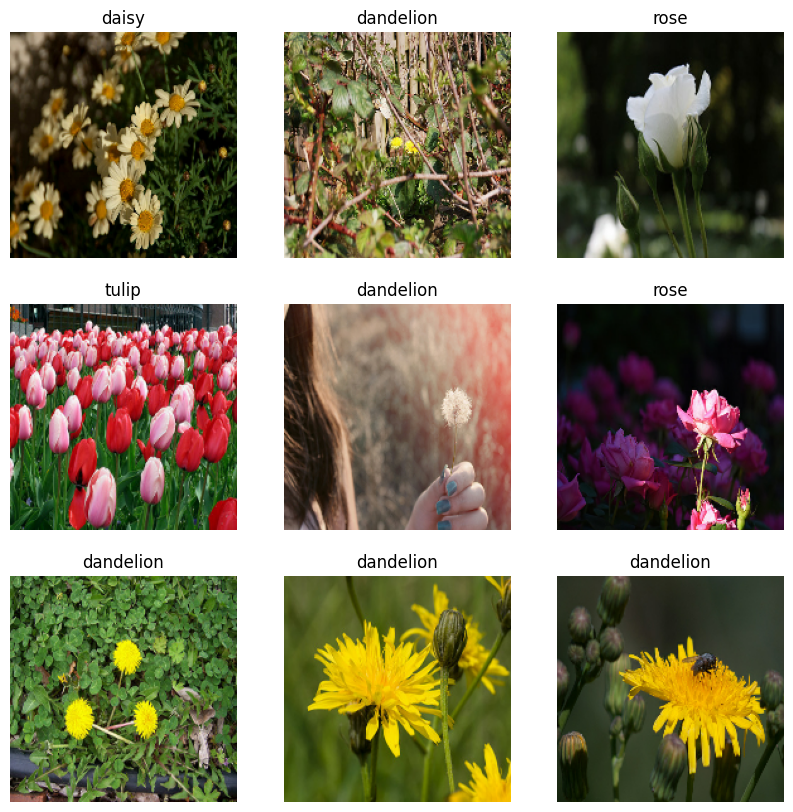

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # just one batch from the training set
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
# 3. Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_size + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze base model


In [ ]:
# 5. Build the model using functional API
inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# 6. Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)


In [ ]:
epochs = 5
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)


Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.5985 - loss: 1.0645 - val_accuracy: 0.8452 - val_loss: 0.4274
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.8656 - loss: 0.3941 - val_accuracy: 0.8543 - val_loss: 0.3862
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8784 - loss: 0.3008 - val_accuracy: 0.8543 - val_loss: 0.3920
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9113 - loss: 0.2718 - val_accuracy: 0.8597 - val_loss: 0.3780
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9172 - loss: 0.2261 - val_accuracy: 0.8652 - val_loss: 0.3724


In [ ]:
# 8. Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.2f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8673 - loss: 0.3681
Validation Accuracy: 0.87


In [ ]:
# 9. Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)


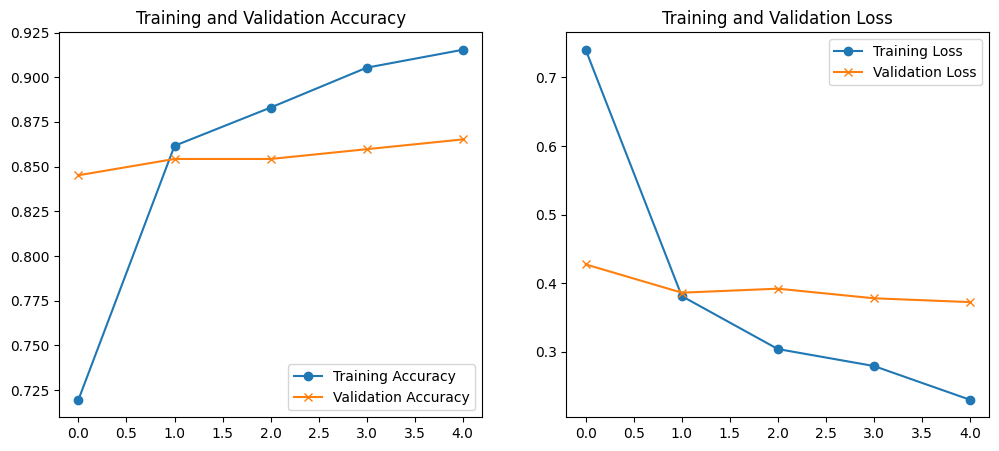

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation -Accuracy: {val_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8510 - loss: 0.4066
Validation Loss: 0.47858181595802307
Validation -Accuracy: 0.8469945192337036


In [ ]:
# Save the trained model
model.save('flower_model.h5')


In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from tensorflow.keras.preprocessing import image


def predict_image_from_url(model, url, class_names):
    # 1. Télécharger l’image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # 2. Afficher l’image originale
    plt.imshow(img)
    plt.title("Image chargée depuis Internet")
    plt.axis("off")
    plt.show()

    # 3. Prétraitement
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # 4. Prédiction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    print(f"✅ Prédiction : {predicted_class} ({confidence:.2%} confiance)")
    return predicted_class

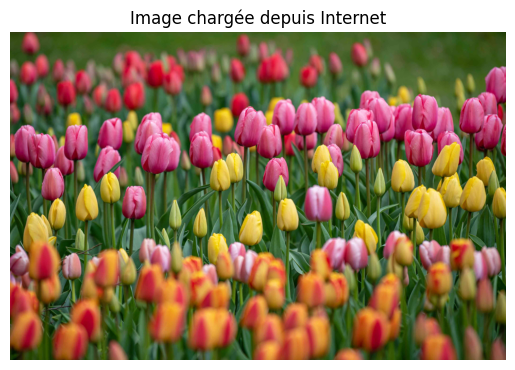

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ Prédiction : dandelion (71.07% confiance)


'dandelion'

In [ ]:
img_url = "https://www.thespruce.com/thmb/mEx6Z5lYPsmNj3y-FFvELC5owjk=/4200x0/filters:no_upscale():max_bytes(150000):strip_icc()/tulip-types-for-spring-garden-1315804-hero-5c10c927e00c459eb24c702be447e50d.jpg"
predict_image_from_url(model, img_url, class_names)
